In [71]:
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras

from functions.image import get_filtered_satellite_float32, remove_noise_satellite


def get_processed_image(coord):
    return get_filtered_satellite_float32(coord, block_size, img_raw, dataset_raw)

In [72]:
# haal dataset op waar je molens kan zien
dataset_raw = rasterio.open("./data/crs.tiff")
img_raw = dataset_raw.read(1)
block_size = 30

In [94]:
from cv2 import cv2 as cv

# haal dataset op waar we kunnen afleiden of we land of water zien
dataset_land = rasterio.open(
    "./data/E000N60_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif")
img_land = dataset_land.read(1)

# we zetten hier alles buiten land op 0
img_land[img_land != 200] = 0  # 200 is ocean index
img_land[img_land == 200] = 1

# dilate om kustlijnen uit resultaat te laten
kernel = np.ones((5, 5), np.uint8)
img_land = cv.erode(img_land, kernel, iterations=5)

In [95]:
import glob

examples = glob.glob("./examples/*/*.png", recursive=True)

In [96]:
import imageio

X = []
Y = []

valid = ["windmills", "boats", "ocean", "beach"]
target = ["windmills", "boats"]

for path in examples:

    category = path.split("/")[2]
    if category not in valid:
        continue

    src = imageio.imread(path)
    src = np.expand_dims(remove_noise_satellite(src) / 255.0, -1)

    # import images oriented 4 ways
    for i in range(4):
        X.append(np.rot90(src.copy(), i))
        if category in target:
            Y.append(1)
        else:
            Y.append(0)

In [97]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 3)
Y_test = keras.utils.to_categorical(Y_test, 3)

In [98]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()

# model gebruikt 3 klassen
# TODO: test 2 klassen
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [99]:
model.fit(X_train, Y_train, epochs=15)

Epoch 1/15
134/134 [==============================] - 1s 7ms/step - loss: 0.4146 - accuracy: 0.8304
Epoch 2/15
134/134 [==============================] - 1s 6ms/step - loss: 0.3269 - accuracy: 0.8761
Epoch 3/15
134/134 [==============================] - 1s 7ms/step - loss: 0.3240 - accuracy: 0.8771
Epoch 4/15
134/134 [==============================] - 1s 7ms/step - loss: 0.3173 - accuracy: 0.8771
Epoch 5/15
134/134 [==============================] - 1s 7ms/step - loss: 0.3155 - accuracy: 0.8778
Epoch 6/15
134/134 [==============================] - 1s 7ms/step - loss: 0.3064 - accuracy: 0.8878
Epoch 7/15
134/134 [==============================] - 1s 6ms/step - loss: 0.3124 - accuracy: 0.8827
Epoch 8/15
134/134 [==============================] - 1s 6ms/step - loss: 0.3056 - accuracy: 0.8871
Epoch 9/15
134/134 [==============================] - 1s 7ms/step - loss: 0.3053 - accuracy: 0.8890
Epoch 10/15
134/134 [==============================] - 1s 7ms/step - loss: 0.3036 - accuracy: 0.8832

In [100]:
model.evaluate(X_test, Y_test, verbose=2)

34/34 - 0s - loss: 0.2863 - accuracy: 0.8865 - 132ms/epoch - 4ms/step


[0.28630331158638, 0.8864915370941162]

<AxesSubplot:>

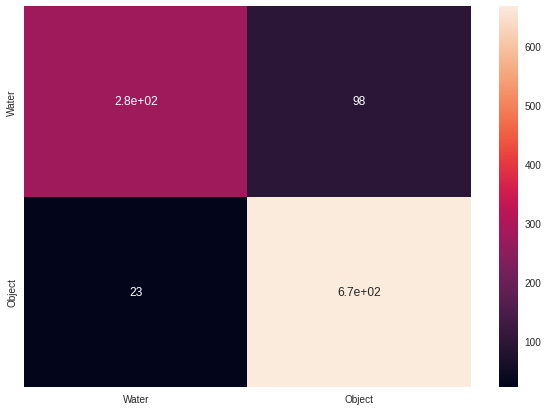

In [101]:
# confusion matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
cm = confusion_matrix([np.argmax(a) for a in Y_test], [np.argmax(a) for a in Y_pred])

df_cm = pd.DataFrame(cm, index=["Water", "Object"], columns=["Water", "Object"])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True)

In [113]:
def plot_windmills(left_top_coord, size=(1200, 800), intensity=1):
    (img_h, img_w) = size
    left_top_x, left_top_y = dataset_raw.index(left_top_coord[0], left_top_coord[1])
    needles = []
    step_size = 15

    x_count = ((img_h - block_size) // step_size)
    for xx in range(left_top_x + block_size // 2, left_top_x + img_w - block_size // 2, step_size):
        for yy in range(left_top_y + block_size // 2, left_top_y + img_h - block_size // 2, step_size):
            cc = dataset_raw.transform * (yy, xx)
            lx, ly = dataset_land.index(cc[0], cc[1])
            if img_land[lx, ly] != 1:
                continue
            needles.append({'lon': cc[0], 'lat': cc[1]})

    test_images = np.stack([get_processed_image(coord) for coord in needles])
    results = model.predict(test_images)

    from matplotlib import pyplot as plt

    search_space = np.copy(img_raw[left_top_x:left_top_x + img_w, left_top_y:left_top_y + img_h])
    search_space = search_space ** (1 / 4)
    highlight = np.max(search_space) * 0.75 * intensity

    found = 0
    previous_i = 0
    coords = []
    found_i = []
    for i, result in enumerate(results):
        if result[1] > result[0]:
            if (i - previous_i <= 2):
                continue
            if (i - x_count in found_i or (i - (x_count * 2)) in found_i or (i + 1 - x_count) in found_i or (i - 1 - x_count) in found_i):
                continue
            found += 1
            previous_i = i
            found_i.append(i)
            coord = needles[i]
            xx, yy = dataset_raw.index(coord['lon'], coord['lat'])
            xx -= left_top_x
            yy -= left_top_y

            search_space[xx - block_size // 2:xx + block_size // 2, yy - block_size // 2] = highlight
            search_space[xx - block_size // 2:xx + block_size // 2, yy + block_size // 2] = highlight
            search_space[xx - block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
            search_space[xx + block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
            coords.append(coord)


    print("found {} windmills".format(found))

    plt.rcParams['figure.figsize'] = [20, 10]
    plt.imshow(search_space)

    return coords

found 44 windmills


[{'lon': 2.6734393328858834, 'lat': 51.47366962760338},
 {'lon': 2.677646589350599, 'lat': 51.47156599937102},
 {'lon': 2.6397812811681556, 'lat': 51.46315148644159},
 {'lon': 2.6629211917240934, 'lat': 51.46315148644159},
 {'lon': 2.6671284481888096, 'lat': 51.461047858209234},
 {'lon': 2.6713357046535253, 'lat': 51.44842608881508},
 {'lon': 2.677646589350599, 'lat': 51.44842608881508},
 {'lon': 2.643988537632872, 'lat': 51.44632246058273},
 {'lon': 2.6502994223299456, 'lat': 51.44632246058273},
 {'lon': 2.6460921658652294, 'lat': 51.44211520411801},
 {'lon': 2.669232076421167, 'lat': 51.44001157588565},
 {'lon': 2.6481957940975875, 'lat': 51.437907947653294},
 {'lon': 2.6734393328858834, 'lat': 51.437907947653294},
 {'lon': 2.620848627076934, 'lat': 51.43580431942094},
 {'lon': 2.6460921658652294, 'lat': 51.43370069118858},
 {'lon': 2.59350146005628, 'lat': 51.43159706295622},
 {'lon': 2.597708716520996, 'lat': 51.42949343472386},
 {'lon': 2.627159511774008, 'lat': 51.42949343472386}

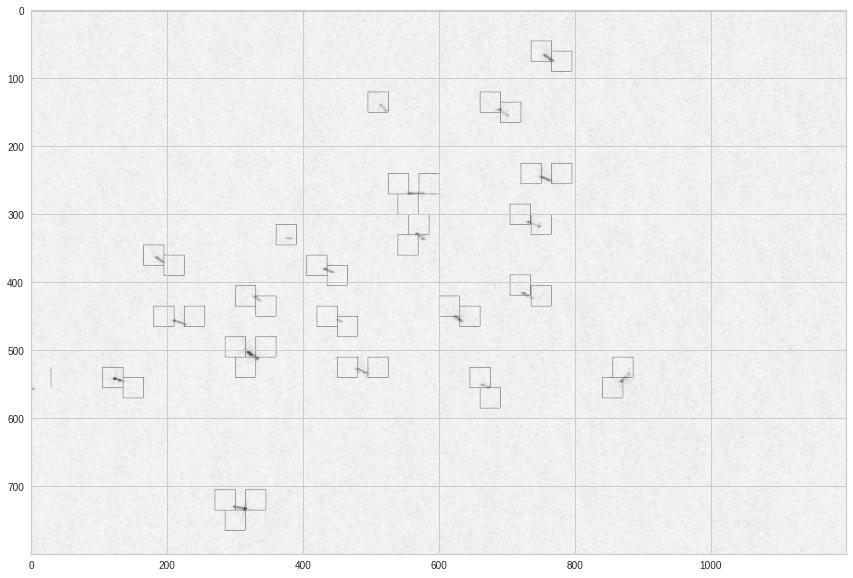

In [114]:
# vb boten
plot_windmills((2.56834, 51.48205))

In [58]:
# vb molens
plot_windmills((1.85730, 52.01960))

ValueError: Found array with dim 4. Estimator expected <= 2.

In [85]:
# vb kust
plot_windmills((1.12835, 51.90720))

ValueError: Found array with dim 4. Estimator expected <= 2.

2021-12-14 23:25:18.468948: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 360072000 exceeds 10% of free system memory.


found 483 windmills


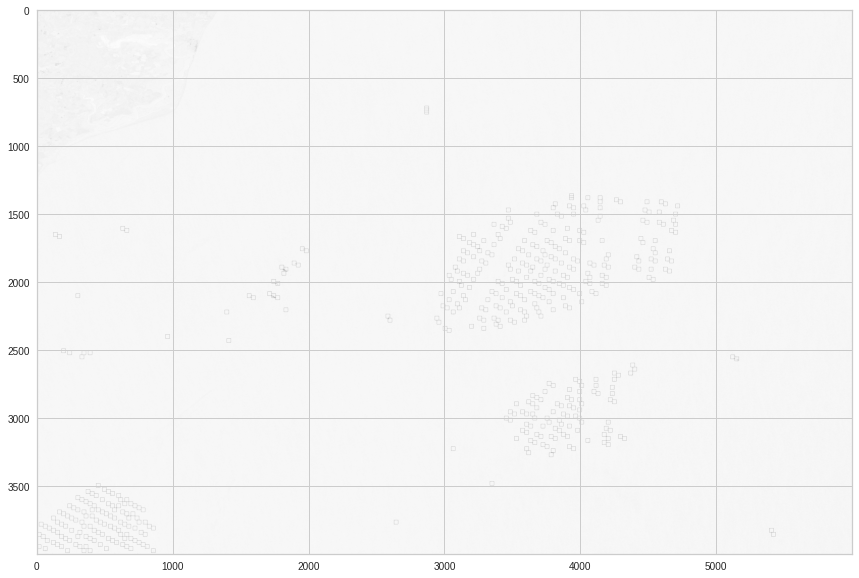

In [115]:
# het duurt redelijk lang voor dit te runnen
coords = plot_windmills((1.4378, 52.1898), (1200 * 5, 800 * 5), intensity=2)

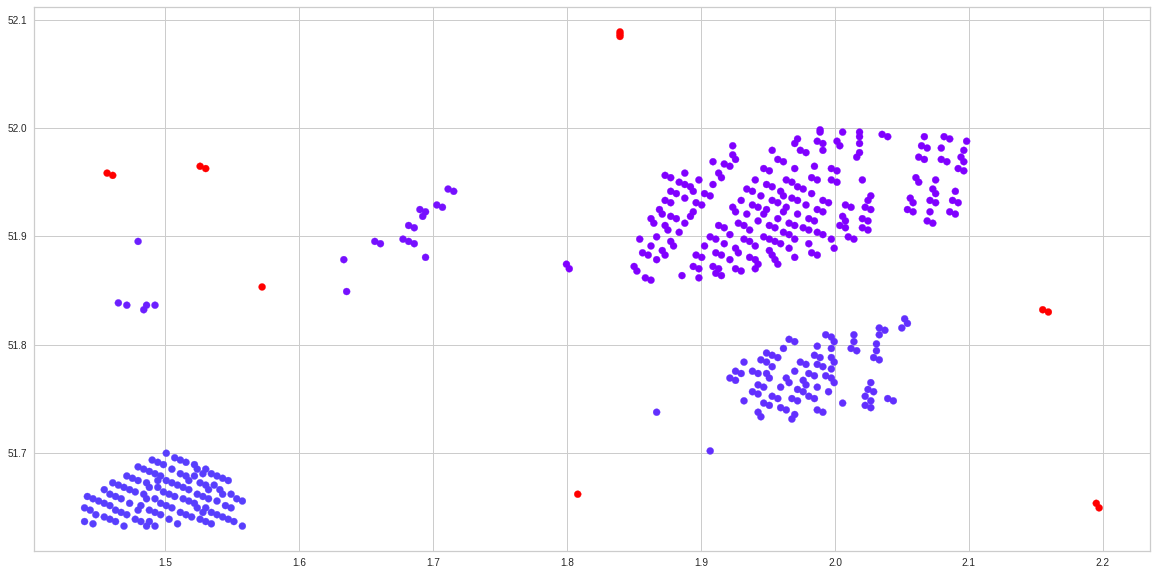

            X          Y  cluster
0    1.839561  52.088911       -1
1    1.839561  52.086807       -1
2    1.839561  52.084704       -1
3    1.988919  51.998455        0
4    1.988919  51.996351        0
..        ...        ...      ...
478  1.534535  51.634527        4
479  1.469323  51.632423        4
480  1.486152  51.632423        4
481  1.492462  51.632423        4
482  1.557675  51.632423        4

[483 rows x 3 columns]


In [116]:
from sklearn import cluster
import matplotlib.cm as cm

colors = np.array(['r', 'g', 'b', 'y', 'c', 't'])
colors = cm.rainbow(np.linspace(0, 1, 50))


def apply(X, algo):
    algo.fit(X)
    labels = algo.labels_.astype(np.int)
    plt.scatter(X[:, 0], X[:, 1], color=colors[labels])
    plt.show()
    return labels


df = pd.DataFrame(coords)
X = df.to_numpy()

#labels = apply(X, cluster.KMeans(n_clusters=4))

labels = apply(X, cluster.DBSCAN(eps=.06))
#apply(X, cluster.SpectralClustering(n_clusters=2, affinity="nearest_neighbors"))

cluster_map = pd.DataFrame()
cluster_map['X'] = X[:, 0]
cluster_map['Y'] = X[:, 1]
cluster_map['cluster'] = labels

print(cluster_map)

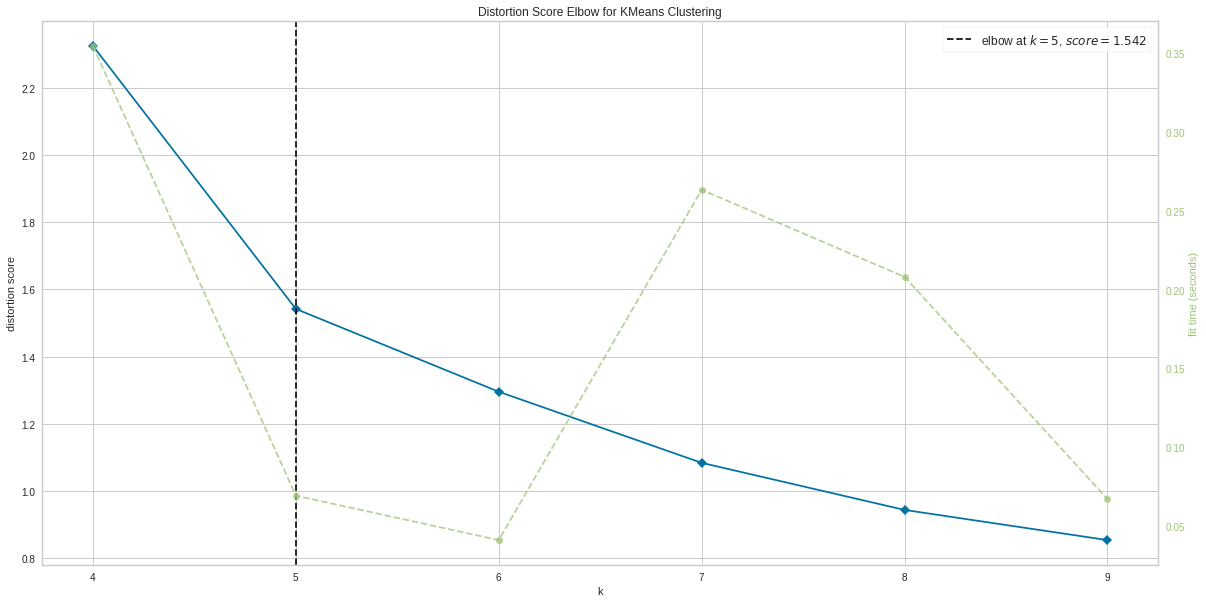

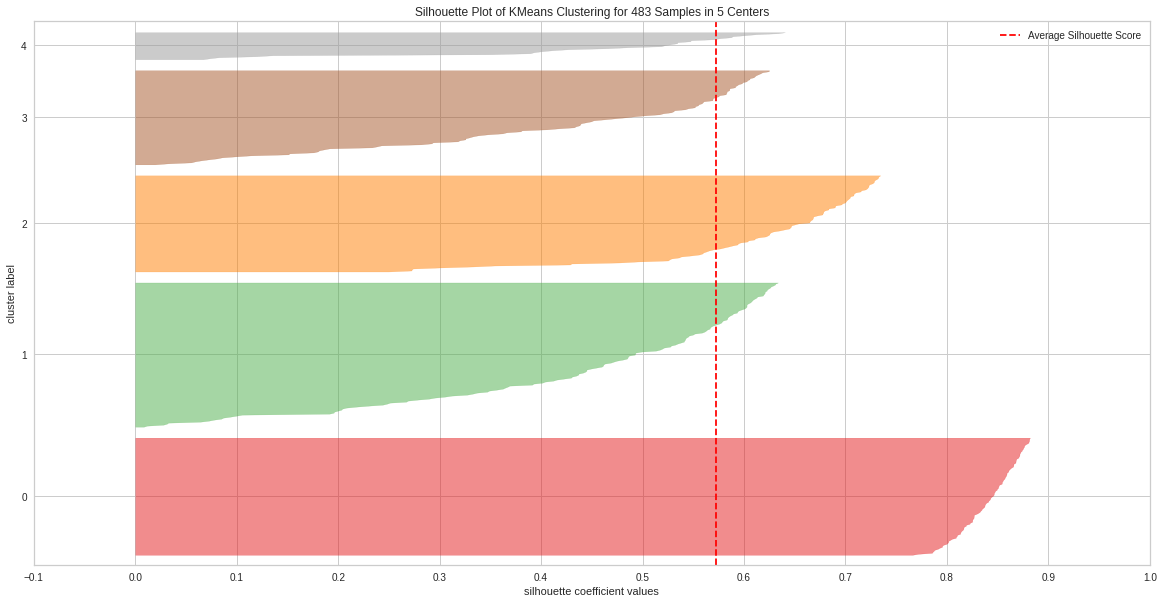

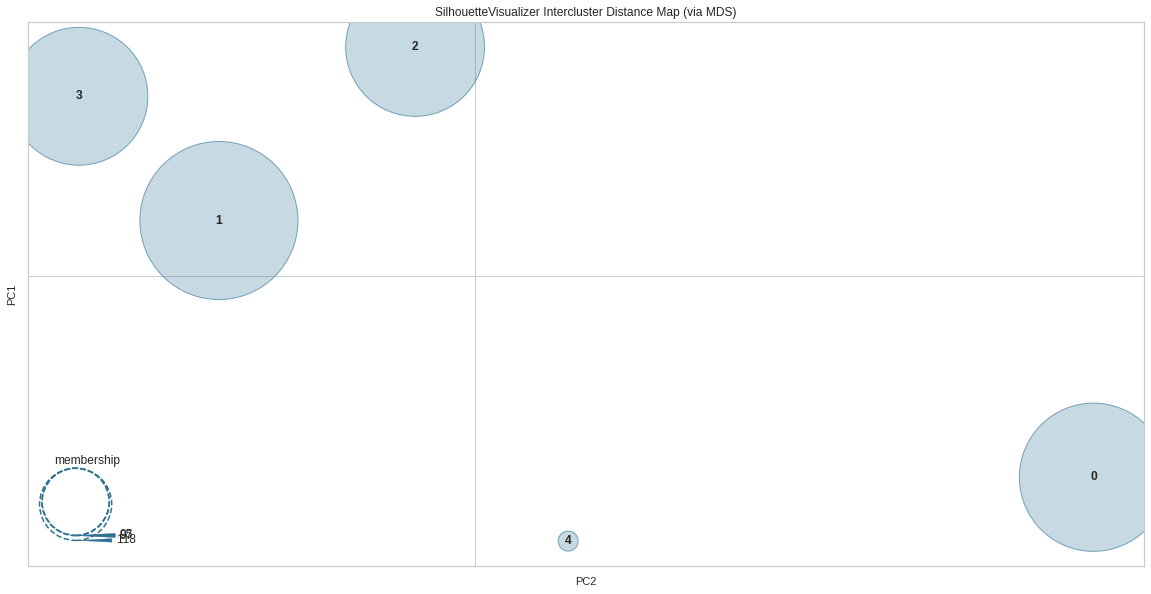

483


In [117]:


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters
# X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)
# X, y = make_blobs(n_samples=1000, centers=5, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4, 10))

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

model = SilhouetteVisualizer(KMeans(5))
model.fit(X)
model.show()

from yellowbrick.cluster import InterclusterDistance

visualizer = InterclusterDistance(model)
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

print(len(X))

In [120]:
from shapely.geometry import LineString
import geopandas as gpd


def bounding_box(x_coordinates, y_coordinates):
    # x_coordinates, y_coordinates = zip(*points)
    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]


list_lon = []
list_lat = []
list_geom = []

column_values = cluster_map["cluster"].values
clusters = np.unique(column_values)
bboxs = []
for cluster in clusters:
    if (cluster_map[cluster_map.cluster == cluster].shape[0] <= 20):
        continue
    bboxs.append(bounding_box(cluster_map[cluster_map.cluster == cluster]['X'],
                              cluster_map[cluster_map.cluster == cluster]['Y']))

l_lats = []
l_lons = []
boxes = []
for bbox in bboxs:
    l_lats.append(bbox[0][0])
    l_lats.append(bbox[1][0])
    l_lats.append(bbox[1][0])
    l_lats.append(bbox[0][0])
    l_lats.append(bbox[0][0])
    l_lons.append(bbox[0][1])
    l_lons.append(bbox[0][1])
    l_lons.append(bbox[1][1])
    l_lons.append(bbox[1][1])
    l_lons.append(bbox[0][1])

    bb = gpd.points_from_xy(l_lats, l_lons, crs="EPSG:4326")

    boxes.append(LineString(bb))
    l_lats = []
    l_lons = []

df_result = gpd.GeoDataFrame({
    'geometry': boxes
})

df_result['geometry']
from shapely.ops import unary_union

cu = unary_union(df_result['geometry']);
df2_result = gpd.GeoDataFrame({
    'geometry': cu
})

df2_result.crs = 'epsg:4326'
df2_result.to_file("result.shp")